<a href="https://colab.research.google.com/github/harryraturi/CrowdinPOC/blob/main/Harish_Rathuri_Starter_code_Assignment_CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [36]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [32]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [33]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [34]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

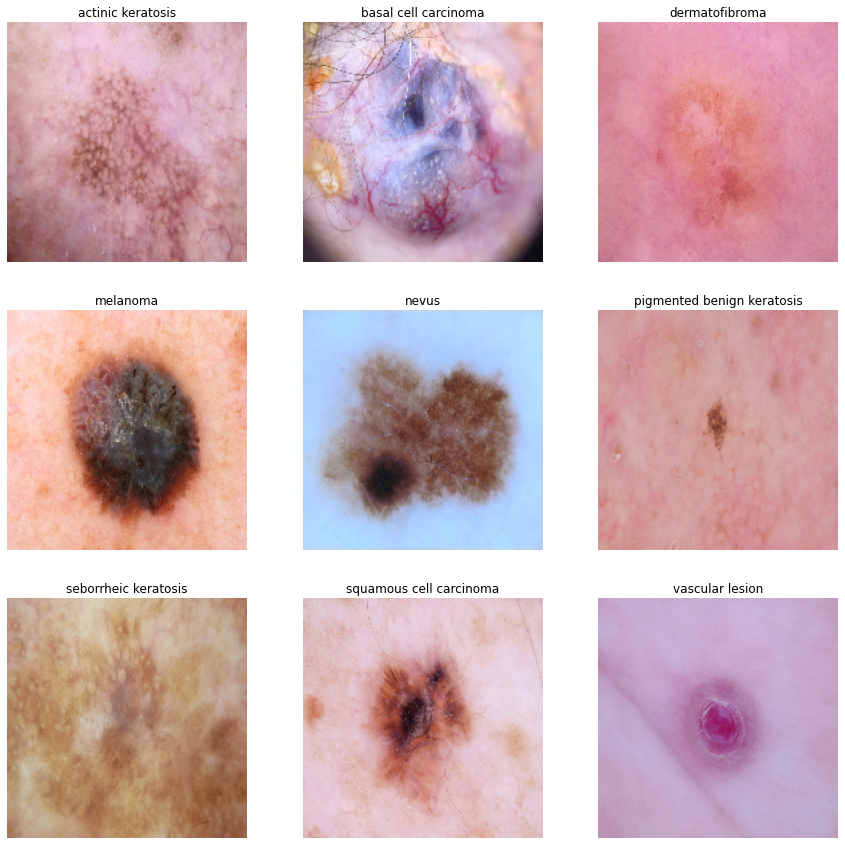

In [38]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [39]:
### Here we will check the image_batch shape and labels_batch shape

for image_batch,labels_batch in train_ds:
  print("image_batch: ",image_batch.shape)
  print("label_batch: ",labels_batch.shape)
  break

image_batch:  (32, 180, 180, 3)
label_batch:  (32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [43]:
### Your code goes here

# num_classes = 9

# model = Sequential()
# model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# ### CNN
# #First Convulation layer
# model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Second Convulation Layer
# model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Third Convulation Layer
# model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Fourth Convulation Layer
# # model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
# # model.add(layers.MaxPool2D(pool_size=(2,2)))

# # model.add(Dropout(0.5))

# #Dropout layer with 50% Fraction of the input units to drop.
# #model.add(layers.Dropout(0.5))

# #Flatten Layer
# ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
# model.add(layers.Flatten())

# #Dense Layer
# model.add(layers.Dense(256, activation='relu'))

# #Dropout layer with 50% Fraction of the input units to drop.
# # model.add(layers.Dropout(0.50))

# #Dense Layer with softmax activation function.
# #Softmax is an activation function that scales numbers/logits into probabilities.
# model.add(layers.Dense(num_classes,activation='softmax'))

# =========== #

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
# model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
# model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

# model.summary()



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [44]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              # loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

### Train the model

In [26]:
# epochs = 20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

Epoch 1/20
56/56 [==============================] - 3s 58ms/step - loss: 0.8194 - accuracy: 0.7054 - val_loss: 2.1323 - val_accuracy: 0.5056
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 0.8178 - accuracy: 0.7031 - val_loss: 1.8633 - val_accuracy: 0.5123
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 0.6885 - accuracy: 0.7483 - val_loss: 1.9432 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 0.6910 - accuracy: 0.7422 - val_loss: 1.9932 - val_accuracy: 0.5526
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 0.6554 - accuracy: 0.7533 - val_loss: 2.1432 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: 0.5917 - accuracy: 0.7667 - val_loss: 2.3965 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 0.5570 - accuracy: 0.8041 - val_loss: 2.1896 - val_accuracy: 0.5280
Epoch 8/20
56

In [46]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 108ms/step - loss: 2.0524 - accuracy: 0.2427 - val_loss: 1.8519 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6692 - accuracy: 0.4169 - val_loss: 1.5652 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4893 - accuracy: 0.4754 - val_loss: 1.4806 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4008 - accuracy: 0.5123 - val_loss: 1.4290 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.3189 - accuracy: 0.5307 - val_loss: 1.3975 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.2758 - accuracy: 0.5580 - val_loss: 1.4277 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.1513 - accuracy: 0.5954 - val_loss: 1.5045 - val_accuracy: 0.4922
Epoch 8/20


### Visualizing training results

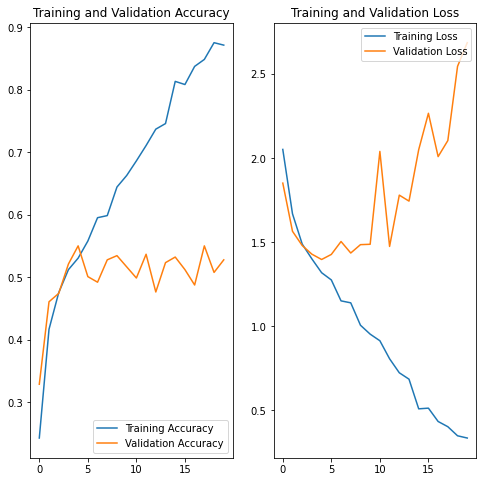

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:

def loss_accuracy(train_ds, val_ds):
  loss, accuracy = model.evaluate(train_ds, verbose=1,)
  loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

  print("Accuracy: ", accuracy)
  print("Validation Accuracy: ",accuracy_v)
  print("Loss: ",loss)
  print("Validation Loss", loss_v)


In [49]:
loss_accuracy(train_ds, val_ds)

14/14 [==============================] - 0s 12ms/step - loss: 2.6875 - accuracy: 0.5280
Accuracy:  0.8900669813156128
Validation Accuracy:  0.5279642343521118
Loss:  0.2900669276714325
Validation Loss 2.687455415725708


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [50]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                 input_shape = (180,180,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),    
])

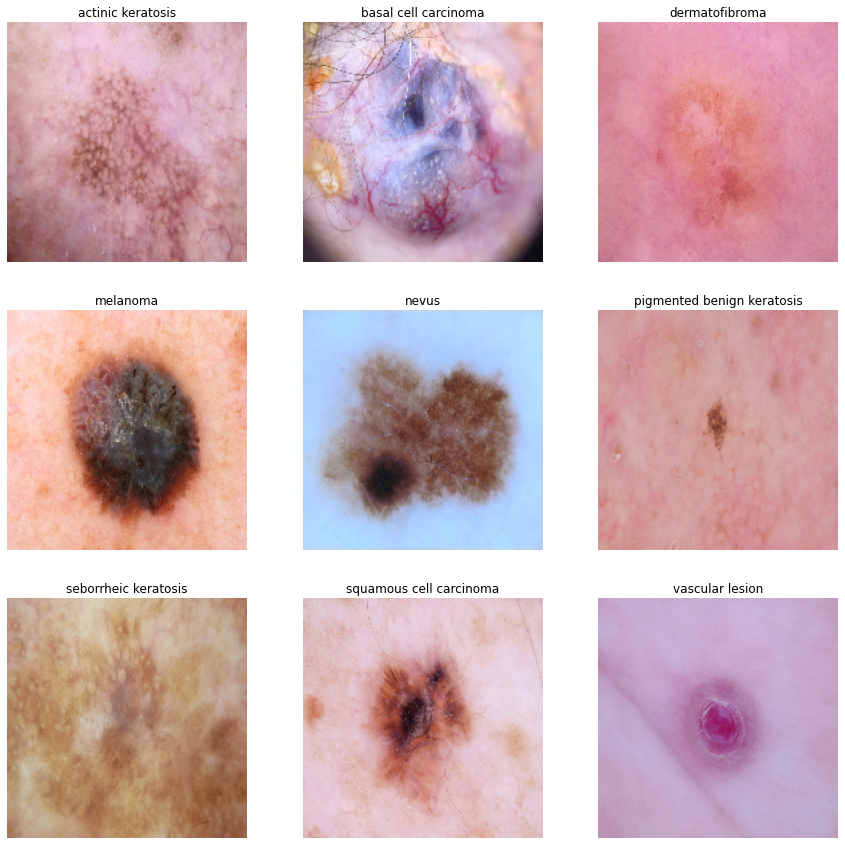

In [52]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")


files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [53]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# ## Your code goes here
# num_classes = 9
# model = Sequential()

# model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# ### CNN
# #First Convulation layer
# model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))

# #Second Convulation Layer
# model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))

# #Third Convulation Layer
# model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.5))

# #Dropout layer with 50% Fraction of the input units to drop.
# #model.add(layers.Dropout(0.5))

# #Flatten Layer
# ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
# model.add(layers.Flatten())

# #Dense Layer
# model.add(layers.Dense(256, activation='relu'))

# #Dropout layer with 50% Fraction of the input units to drop.
# # model.add(layers.Dropout(0.50))

# #Dense Layer with softmax activation function.
# #Softmax is an activation function that scales numbers/logits into probabilities.
# model.add(layers.Dense(num_classes, activation='softmax'))



# ============== #

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = data_augmentation

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compiling the model

In [54]:
## Your code goes here
# model.compile(optimizer='adam',
#               # loss="sparse_categorical_crossentropy",
#               loss=SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

# callbacks = [checkpoint,earlystop]

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                  

### Training the model

In [56]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [checkpoint,earlystop]
)


Epoch 1/20


56/56 [==============================] - ETA: 0s - loss: 2.0345 - accuracy: 0.2550
Epoch 1: val_accuracy improved from -inf to 0.39150, saving model to model.h5
56/56 [==============================] - 16s 183ms/step - loss: 2.0345 - accuracy: 0.2550 - val_loss: 1.7490 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.6745 - accuracy: 0.3990
Epoch 2: val_accuracy improved from 0.39150 to 0.48098, saving model to model.h5
56/56 [==============================] - 11s 194ms/step - loss: 1.6745 - accuracy: 0.3990 - val_loss: 1.5187 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5519 - accuracy: 0.4537
Epoch 3: val_accuracy did not improve from 0.48098
56/56 [==============================] - 10s 181ms/step - loss: 1.5519 - accuracy: 0.4537 - val_loss: 1.4642 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.4784 - accuracy: 0.4877
Epoch 4: val_accuracy improve

In [75]:
# loss_accuracy(train_ds, val_ds)

### Visualizing the results

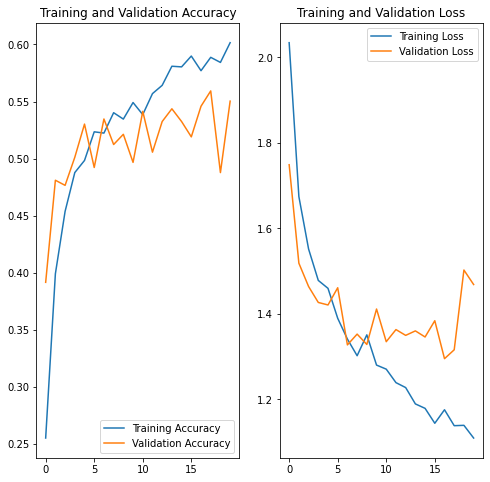

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [59]:
## Your code goes here.

# import matplotlib.pyplot as plt
# data = dict()

# for i in class_names:
#   data[i] = []

# # plt.figure(figsize=(10, 10))
# for images, labels in train_ds:
#   for i in range(9):
#     data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

# for i in data:
#   data[i] = len(data[i]) 

# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(10)

# plt.bar(range(len(data)), list(data.values()), align='center')
# plt.xticks(range(len(data)), list(data.keys()), rotation=45)
# plt.show()


def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,vascular lesion,139
4,actinic keratosis,114
5,seborrheic keratosis,77
6,squamous cell carcinoma,181
7,basal cell carcinoma,376
8,dermatofibroma,95


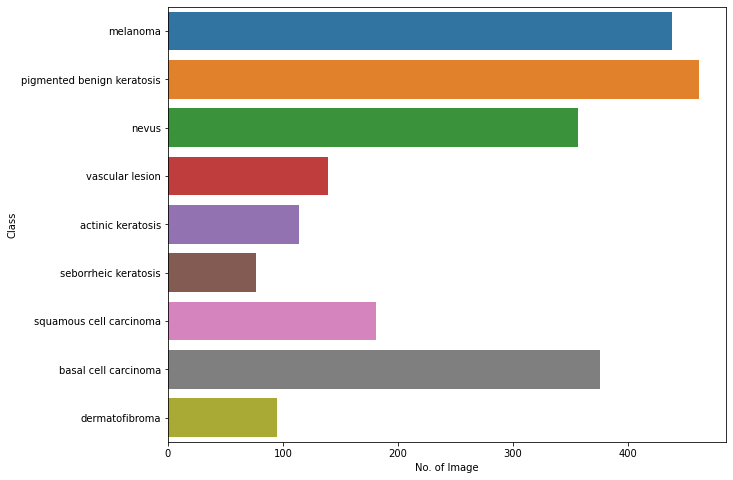

In [60]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [61]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [62]:
path_to_training_dataset="/content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/"
# path_to_training_dataset="/content/gdrive/MyDrive/MLDataset/SkinCancerISICImages/TrainAugment/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28E0919250>: 100%|██████████| 500/500 [00:19<00:00, 25.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28E0FA3250>: 100%|██████████| 500/500 [00:19<00:00, 25.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2903E39D60>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F28E085F490>: 100%|██████████| 500/500 [01:38<00:00,  5.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28E1331190>: 100%|██████████| 500/500 [01:45<00:00,  4.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28E15DEEE0>: 100%|██████████| 500/500 [00:28<00:00, 17.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F28E0FEDE20>: 100%|██████████| 500/500 [00:48<00:00, 10.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28E1398580>: 100%|██████████| 500/500 [00:21<00:00, 23.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F28E0F8D280>: 100%|██████████| 500/500 [00:20<00:00, 24.41 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [64]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [65]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [66]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [68]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [69]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = df2

In [70]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
vascular lesion               500
actinic keratosis             500
seborrheic keratosis          500
squamous cell carcinoma       500
basal cell carcinoma          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [71]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [72]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train="/content/gdrive/MyDrive/MyApps/dataset/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [76]:
## your code goes here

# num_classes = 9
# model = Sequential()
# model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# # model = Sequential(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (180, 180, 3)))

# ### CNN
# #First Convulation layer
# model.add(layers.Conv2D(32,kernel_size=(3,3), activation='relu', padding='same'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# #Second Convulation Layer
# model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# #Third Convulation Layer
# model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# #Dropout layer with 50% Fraction of the input units to drop.
# #model.add(layers.Dropout(0.5))

# #Flatten Layer
# ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
# model.add(layers.Flatten())

# #Dense Layer
# model.add(layers.Dense(256, activation='relu'))
# model.add(BatchNormalization())

# #Dropout layer with 50% Fraction of the input units to drop.
# # model.add(layers.Dropout(0.50))

# #Dense Layer with softmax activation function.
# #Softmax is an activation function that scales numbers/logits into probabilities.
# model.add(layers.Dense(num_classes, activation='softmax'))


# ========================= #

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))




#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [77]:
## your code goes here
# model.compile(optimizer='adam',
#               # loss="sparse_categorical_crossentropy",
#               loss=SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

# callbacks = [checkpoint,earlystop]

In [78]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:**  Train your model

In [79]:
epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code
# epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [checkpoint,earlystop]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.0046 - accuracy: 0.2346
Epoch 1: val_accuracy improved from -inf to 0.38679, saving model to model.h5
169/169 [==============================] - 36s 196ms/step - loss: 2.0046 - accuracy: 0.2346 - val_loss: 1.6775 - val_accuracy: 0.3868
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.5766 - accuracy: 0.3996
Epoch 2: val_accuracy improved from 0.38679 to 0.44989, saving model to model.h5
169/169 [==============================] - 35s 203ms/step - loss: 1.5772 - accuracy: 0.3995 - val_loss: 1.4566 - val_accuracy: 0.4499
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4507 - accuracy: 0.4572
Epoch 3: val_accuracy improved from 0.44989 to 0.50557, saving model to model.h5
169/169 [==============================] - 35s 204ms/step - loss: 1.4507 - accuracy: 0.4572 - val_loss: 1.2509 - val_accuracy: 0.5056
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 

#### **Todo:**  Visualize the model results

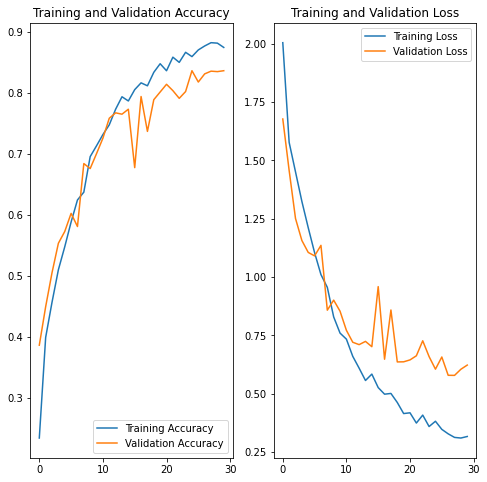

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

